In [30]:
from bgunfolding import Sampler, hist, hist_error
from bgunfolding import MLE, MCMC
from bgunfolding.metrics import emd
from bgunfolding.tikhonov_matrices import second_order_central

from bgunfolding.mcmc import log_prob

import numpy as np
import matplotlib.pyplot as plt

# Read samples
s = Sampler()
s.read_sample('../data/sample_0.b')

# Load quantities of one sample
f, g, b, A, area_eff, acceptance, eff = s.load_one(i = 0)

Data succesfully read. (n_samples : 20)


In [14]:
# Maximum Likelihood Unfolding
C = second_order_central(len(f) - 2)
bounds = [[1e-12, None] for i in range(s.n_bins_true + 2)]

x0 = np.ones(len(f)) / len(f)
mle = MLE(C = C, 
          x0 = x0,
          bounds = bounds)

mle.fit(f, g, b, A, area_eff, acceptance, eff)

In [16]:
# Estimate Regularization Strength
tau_est = mle.estimate_tau(0, 3, n_tau = 500, log = True)

In [23]:
# Predict using MLE
f_est_mle = mle.predict(tau_est)
cov = np.linalg.inv(mle.predict_hess(f_est_mle, tau_est))
f_est_mle_err = np.sqrt(np.diag(cov))

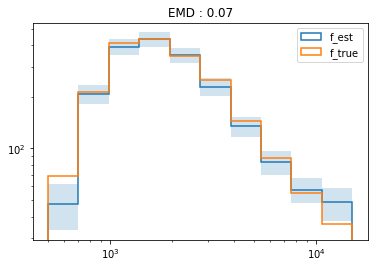

In [48]:
fig, ax = plt.subplots()

ax.set_title(f'EMD : {emd(f_est_mle, f).round(2)}')
hist(ax, f_est_mle, s.bins_true, label = 'f_est')
hist(ax, f, s.bins_true, label = 'f_true')
hist_error(ax, f_est_mle[1:-1], f_est_mle_err, s.bins_true[1:-1], cut_overflow=False)

In [33]:
# MCMC
mcmc = MCMC()
mcmc.fit(f, g, b, A, area_eff, acceptance, eff)

nwalkers = 100
ndim = len(f)

mcmc.init_sampler(log_prob = log_prob,
                  nwalkers = nwalkers, 
                  ndim = ndim,
                  C = C, 
                  tau = tau_est)

In [34]:
p0 = np.abs(np.random.randn(nwalkers, ndim))
res = mcmc.run_mcmc(p0, 
                    tau_est, 
                    nburnin = 500, 
                    nmcmc = 1500)

In [39]:
percentiles = res['percentiles'] # 16, 50, 84
f_est = percentiles.T[1] # Median

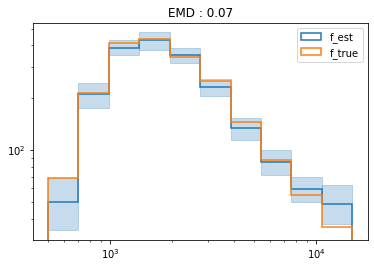

In [55]:
fig, ax = plt.subplots()

ax.set_title(f'EMD : {emd(f_est, f).round(2)}')

for i in range(len(f) - 2):
    x = np.linspace(s.bins_true[1:-1][i], 
                    s.bins_true[1:-1][i+1], 100)
    
    # fill 1 sigma credible interval
    plt.fill_between(x, 
                     percentiles.T[0][1:-1][i],
                     percentiles.T[2][1:-1][i], color = 'C0', alpha = 0.25)

    
hist(ax, f_est, s.bins_true, label = 'f_est')
hist(ax, f, s.bins_true, label = 'f_true')